In [1]:
%load_ext autoreload
%autoreload 2

import math
import pyibex as ia 
from pyibex.geometry import SepPolarXY
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import utils.utils as u 
import numpy as np
from numpy import pi 
import random

from math import cos, sin

# Installing dependencies 

The list of necessary python modules is shown in the first cell.  
For convenience, a conda environment is available in `conda-envs/csp-env.txt` and it can be installed running:

`conda create --name csp-fuzzy-guacamole --file conda-envs/csp-env.txt `

# Related work

[5] investigates the use of interval analysis to solve the problem of tracking a manueuvering target using range-only measurements obtained from a multistatic radar (one transmitter, multiple receivers). 
Some measurement uncertainties are considered affecting both the precision and reliability of the tracking. The paper uses an Interval-Based Approach (TIBA) to compute the set of all feasible configurations for the target that are consistent with the measurements, and results are compared to a more conventional particle filter approach.

# Two dimenstional bistatic geometry 

Let us consider the geometry given in the figure below, with source and receiver not colocated.
Let $\mathbf{s}_k = [s^x_k, s^y_k]$ denote the source position at time $k$, while the receiver array position and its heading angle are denoted by $\mathbf{r}_k = [r^x_k, r^y_k]$ and $\theta_k$, respectively.

The receiver array measures the bistatic range $b_k$ from source to target to receiver, and its bearing:

$b_k = ||\mathbf{x}^p_k-\mathbf{r}_k|| + ||\mathbf{x}^p_k-\mathbf{s}_k||$  
$\theta_k = tan^{-1} ( \frac{y_k - r^y_k}{x_k - r^x_k} ) - h_k$

Note that ambiguous contacts have the same bistatic range measurements but different bearing angles ($-\theta_k$).


![bistatic-geometry](pics/bistatic-tracking/bistatic-geometry.png)

The following code implements the equations above:

In [2]:
#export
def check_np(v):
    if type(v) != np.ndarray: 
        #print('v = np.asarray(v)')
        v = np.asarray(v)
    return v

Let's now define a target class

In [3]:
class Target:
    def __init__(self, x, y, v, name='T0'):
        self.x = check_np((x, y)).reshape(2,1)
        self.v = v
        self.name = name

    def move(self, t0, tf, dt):
        x = self.x
        for t in np.arange(t0, tf, dt):
            v = x[:,-1] + dt*self.v
            v = v.reshape(2, 1)
            x = np.append(x, v, axis=1)
        self.x = x
    
    def get_position(self):
        return list(self.x[:,-1])
        
    def plot(self):
        plt.plot(self.x[0,:], self.x[1,:], marker='.', markersize=1, color='red')
        
    def __repr__(self):
        #        [print(x, y) for x,y in zip(self.x[0,:], self.x[1,:])]
        return f'Target {self.name}: x,y=({self.x[0,-1]:5.2f}, {self.x[1,-1]:5.2f}), v={self.v}'


<IPython.core.display.Javascript object>


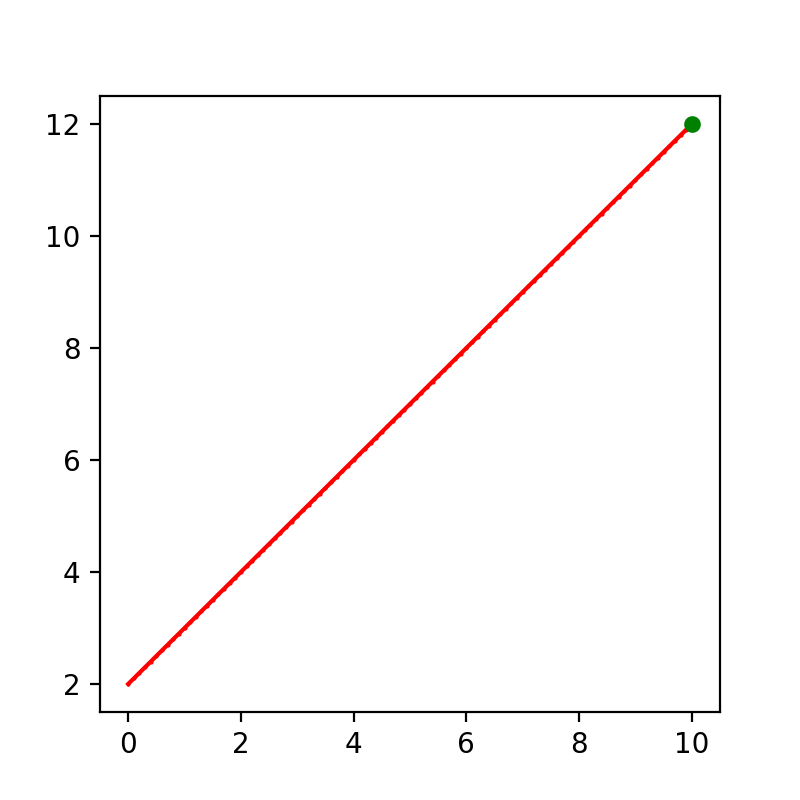

Target T0: x,y=(10.00, 12.00), v=1


In [4]:
# Test the Target class
%matplotlib notebook
fig, ax = plt.subplots(1, 1, figsize=(4,4))        
target = Target(0, 2, 1)
target.move(0., 10, 0.1)
target.plot()
print(target)

x, y = target.get_position()
plt.plot(x, y, marker='.', markersize=10, color='green')

And a Sonar class. This class only does the detection part, whereas I define a tracker class that build on top of the results that this class provides.

In [5]:
#export
class Sonar:
    def __init__(self, tx, rx, err_range=0, err_bearing=0):
        """tx: x, y
           rx: x, y, theta"""        
        self.tx = check_np(tx)
        self.rx = check_np(rx)
        self.err_range = err_range
        self.err_bearing = err_bearing
        
    def get_rx(self):
        return self.rx
        
    def get_array_heading(self):
        return self.rx[2]
    
    def get_errors(self):
        return self.err_range, self.err_bearing
        
    def detect(self, target):
        target = check_np(target)
        b = np.linalg.norm(target-self.rx[0:2]) + np.linalg.norm(target-self.tx)
        theta = math.atan2(target[1]-self.rx[1], target[0]-self.rx[0]) - self.rx[2]
        return b, theta # range, bearing

    def get_target(self, t_range, t_bearing):
        delta =  np.linalg.norm(self.tx - self.rx[0:2])
        alpha = math.atan2(self.tx[1]-self.rx[1], self.tx[0]-self.rx[0]) - t_bearing - self.rx[2]
        r = (t_range**2 - delta**2)/(2*(t_range - delta*cos(alpha)))
        tgt_x = self.rx[0] + r*cos(t_bearing + self.rx[2])
        tgt_y = self.rx[1] + r*sin(t_bearing + self.rx[2])

        return tgt_x, tgt_y
    
    def refer_to_rx(self, t_range, t_bearing):
        delta =  np.linalg.norm(self.tx - self.rx[0:2])
        alpha = math.atan2(self.tx[1]-self.rx[1], self.tx[0]-self.rx[0]) - t_bearing - self.rx[2]        
        r = (t_range**2 - delta**2)/(2*(t_range - delta*cos(alpha)))
    
        return r, t_bearing + self.rx[2]
    
    def get_bistatic_projections(self, t_range, t_bearing):
        delta =  np.linalg.norm(self.tx - self.rx[0:2])
        alpha = math.atan2(self.tx[1]-self.rx[1], self.tx[0]-self.rx[0]) - t_bearing - self.rx[2]        
        r = (t_range**2 - delta**2)/(2*(t_range - delta*cos(alpha)))
    
        Sx = r*cos(t_bearing + self.rx[2])
        Sy = r*sin(t_bearing + self.rx[2])        
    
        return Sx, Sy

    def plot(self):
        plt.plot(self.tx[0], self.tx[1], marker='.', markersize=10, color='black')
        plt.plot(self.rx[0], self.rx[1], marker='.', markersize=10, color='yellow')


We can now try the class functionalities:

In [6]:
tx = -1, 0
rx = 1, 0, 0.78
tgt = 2, 1.4

sonar = Sonar(tx, rx)
tgt_x, tgt_y = sonar.get_target(*sonar.detect(tgt))

assert abs(np.linalg.norm(check_np(tgt)-check_np((tgt_x, tgt_y))))<1e-3

#print(sonar.get_bistatic_projections(*sonar.detect(tgt)))

Since we want to know the position of the target $tgt$, we can:

$tgt = rx + S$  (since $rx$ is know, the function $f: (m-v) -> p$)  
$rx = tgt-S$  (this corresponds to $f^-1$).

In [7]:
X = ia.IntervalVector([[-20, 20],[-20, 20]])

tx = -1, 0
rx = 1, 0, 0
target = Target(x=-4, y=4, v=1)


sonar = Sonar(tx, rx, err_range = 0.5, err_bearing = 0.2)
tgt_x, tgt_y = sonar.get_target(*sonar.detect(target.get_position()))

print(f'The real target position: {target.get_position()}')
print(f'Sonar estimated target: {tgt_x:5.2f}, {tgt_y:5.2f}')

The real target position: [-4, 4]
Sonar estimated target: -4.00,  4.00


# Using Interal Analysis for Target Tracking

Here we apply interval analysis to the measurements that the Sonar provides to localise the target.  
Note that we use the results from the cell above.

In [8]:
t_range, t_bearing = sonar.detect(target.get_position())
print(f'Sonar measurement: {t_range}, {t_bearing}')

Sx, Sy = sonar.get_bistatic_projections(t_range, t_bearing)

rx_x, rx_y, rx_theta = sonar.get_rx() 
t_rx_range, t_rx_bearing = sonar.refer_to_rx(t_range, t_bearing)

err_range , err_bearing = sonar.get_errors()



I_range = ia.Interval(t_rx_range-err_range, t_rx_range+err_range)
I_bearing = ia.Interval( t_rx_bearing-err_bearing, t_rx_bearing + err_bearing)
print(f'Range Interval  : {I_range}')
print(f'Bearing Interval: {I_bearing}')

separator_port = SepPolarXY(I_range, I_bearing)
separator_starbrd = SepPolarXY(I_range, -I_bearing)


Sonar measurement: 11.403124237432849, 2.4668517113662407
Range Interval  : [5.90312, 6.90312]
Bearing Interval: [2.26685, 2.66685]


Let's define the functions that corresponds to the measurements:

In [9]:
# f_forward = ia.Function('rx_x', 'rx_y', '(rx_x+%f; rx_y+%f)' % (Sx, Sy))
# f_backward = ia.Function('tgt_x', 'tgt_y', '(tgt_x-%f; tgt_y-%f)' % (Sx, Sy))

f_forward = ia.Function('Sx', 'Sy', '(%f + Sx; %f + Sy)' % (rx_x, rx_y))
f_backward = ia.Function('tgt_x', 'tgt_y', '(tgt_x-%f; tgt_y-%f)' % (rx_x, rx_y))

separator_t_port = ia.SepTransform(separator_port, f_backward, f_forward)
separator_t_starbrd = ia.SepTransform(separator_starbrd, f_backward, f_forward)
#separators.append(separator_t)
    
# # build the final separator using the q relaxed intersection
# separator = ia.SepQInterProjF(separators)
# separator.q = 1

in_boxes_port, out_boxes_port, maybe_boxes_port = ia.pySIVIA(X, separator_t_port, epsilon=0.1, draw_boxes=False) 
in_boxes_starbrd, out_boxes_starbrd, maybe_boxes_starbrd = ia.pySIVIA(X, separator_t_starbrd, epsilon=0.1, draw_boxes=False) 

number of separation 163 / number of boxes 252
number of separation 163 / number of boxes 257


<IPython.core.display.Javascript object>


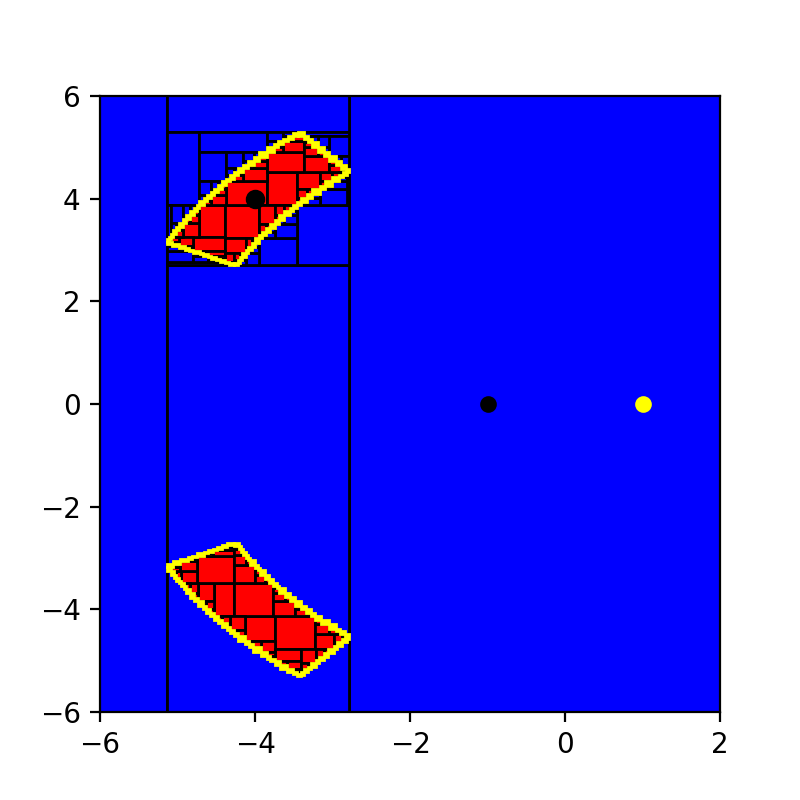

In [10]:
%matplotlib notebook
fig, ax = plt.subplots(1, 1, figsize=(4,4))

for b in out_boxes_port:
    u.IA.draw_box(b, edgecolor='black', facecolor='blue', ax=ax)    
for b in in_boxes_port:
    u.IA.draw_box(b, edgecolor='black', facecolor='red', ax=ax)    
for b in maybe_boxes_port:
    u.IA.draw_box(b, edgecolor='yellow', facecolor='yellow', ax=ax)
    
# for b in out_boxes_starbrd:
#     u.IA.draw_box(b, edgecolor='black', facecolor='blue', ax=ax)    
for b in in_boxes_starbrd:
    u.IA.draw_box(b, edgecolor='black', facecolor='red', ax=ax)    
for b in maybe_boxes_starbrd:
    u.IA.draw_box(b, edgecolor='yellow', facecolor='yellow', ax=ax)
    
        

sonar.plot()
x, y = target.get_position()
plt.plot(x, y, marker='.', markersize=12, color='black')

ax.set_xlim(-6, 2)
ax.set_ylim(-6, 6);

Alright! We seem to be on the right track. We got the target and the sets associated to the measurements that we have.

In [11]:
def separator_union(separators):
    """This function applies the interval union operator recursively to a list of separators"""
    separator_u = 'empty'
    for s in separators:
        if separator_u == 'empty':
            separator_u = s
        else:
            separator_u = separator_u | s   # Union 
            
    return separator_u

In [12]:
class IA2DTracker:
    def __init__(self, sonar, history=1):
        self.sonar = sonar
        self.solution = [], [], []
        self.separators      = []
        self.target_hist     = []
        self.targets         = []
        self.allintersections = []
        
    def track_one_contact(self, target):
        """track_one_contact applies the measurement functions and generates separators based on the measurements."""
        t_range, t_bearing = self.sonar.detect(target.get_position()) # bistatic values
        t_rx_range, t_rx_bearing = sonar.refer_to_rx(t_range, t_bearing) # referred to the rx position
        
        rx_x, rx_y, rx_theta = self.sonar.get_rx() 
        err_range, err_bearing = sonar.get_errors()
        
        I_range = ia.Interval(t_rx_range-err_range, t_rx_range+err_range)
        I_bearing = ia.Interval( t_rx_bearing-err_bearing, t_rx_bearing + err_bearing)

        separator_port = SepPolarXY(I_range, I_bearing)
        separator_starbrd = SepPolarXY(I_range, -I_bearing)

        f_forward = ia.Function('Sx', 'Sy', '(%f + Sx; %f + Sy)' % (rx_x, rx_y))
        f_backward = ia.Function('tgt_x', 'tgt_y', '(tgt_x-%f; tgt_y-%f)' % (rx_x, rx_y))

        separator_t_port = ia.SepTransform(separator_port, f_backward, f_forward)
        separator_t_starbrd = ia.SepTransform(separator_starbrd, f_backward, f_forward)
        
        return separator_t_port | separator_t_starbrd
        
    def track_current_targets(self, targets):     
        separators = []
        self.targets = targets
        for target in self.targets:
            separators.append(self.track_one_contact(target))
        
        separator_f = union_separators(separators)
                
        return separator_f            
    
    def track(self, targets, q=0, keep_history=False):                
        self.targets = targets
        print(f'>> Number of new targets is: {len(self.targets)}')
        separators = []
        for idx, t in enumerate(targets):
            print(f'[SIVIA] analysis target {t}')
            separators.append(self.track_one_contact(t))

        # we want now to do the relaxed intersection    
        qrelaxed_separator = ia.SepQInterProjF(separators)  
        if len(separators) == 1:
            qrelaxed_separator.q = 0 # number of set to relax
        else:
            # build the final separator for each current target using the q relaxed intersection
            print(f'Running Relaxed Intersection: q:{q}')
            if q >=  len(targets):
                q = len(targets)-1
                print(f'>> Maximum relaxation is q:{q}')

            qrelaxed_separator.q = q

        #in_boxes, out_boxes, maybe_boxes = ia.pySIVIA(X, qrelaxed_separator, epsilon=0.1, draw_boxes=False) 
        if keep_history:
            self.target_hist += targets            
                
        self.find_target(qrelaxed_separator, epsilon=0.1)
        
        return qrelaxed_separator
                                       
    def find_target(self, separator, epsilon=0.1):       
        self.solution = [], [], []
        in_boxes, out_boxes, maybe_boxes = ia.pySIVIA(X, separator, epsilon=epsilon, draw_boxes=False)          
        self.solution = in_boxes, out_boxes, maybe_boxes
        return self.solution
    
    def add_detections(self, targets):
        self.targets += targets
        
    def find_intersection(self, X, q):
        self.solution = [], [], []
        separators = []
        for idx, t in enumerate(self.targets):
            separators.append(self.track_one_contact(t))

        # we want now to do the relaxed intersection    
        qrelaxed_separator = ia.SepQInterProjF(separators)                  
        qrelaxed_separator.q = q # number of set to relax

        in_boxes, out_boxes, maybe_boxes = ia.pySIVIA(X, qrelaxed_separator, epsilon=0.1, draw_boxes=False) 
        self.solution = in_boxes, out_boxes, maybe_boxes
        return self.solution, qrelaxed_separator
            
            
    def find_best_intersection(self, X):                
        self.solution = [], [], []
        for _q in range(0, len(self.targets)):
            print(f'- find_best_intersection: q:{_q}')
            
            separators = []
            for idx, t in enumerate(self.targets):
                separators.append(self.track_one_contact(t))

            # we want now to do the relaxed intersection    
            qrelaxed_separator = ia.SepQInterProjF(separators)                  
            qrelaxed_separator.q = _q # number of set to relax

            in_boxes, out_boxes, maybe_boxes = ia.pySIVIA(X, qrelaxed_separator, epsilon=0.1, draw_boxes=False) 
            if len(in_boxes) > 0:
                print(f'Maximum number of measurements matched with q:{qrelaxed_separator.q}.')
                self.solution = in_boxes, out_boxes, maybe_boxes
                return self.solution, qrelaxed_separator  
            
        return None, None            
               
    def find_all_intersections(self, X):                            
        in_boxes, out_boxes, maybe_boxes, qs = [], [], [], []
        for _q in range(0, len(self.targets)):
            print(f'- find_all_intersections: q:{_q}')            
            
            separators = []
            for idx, t in enumerate(self.targets):
                separators.append(self.track_one_contact(t))

            # we want now to do the relaxed intersection    
            qrelaxed_separator = ia.SepQInterProjF(separators)                  
            qrelaxed_separator.q = _q # number of set to relax

            inb, outb, mayb = ia.pySIVIA(X, qrelaxed_separator, epsilon=0.1, draw_boxes=False) 
            in_boxes.append(inb)
            out_boxes.append(outb)
            maybe_boxes.append(mayb)
            qs.append(_q)
            
        in_boxes.reverse()
        out_boxes.reverse()
        maybe_boxes.reverse()
        qs.reverse()
        self.allintersections = in_boxes, out_boxes, maybe_boxes, qs
            
        print(f'len(in_boxes) list is: {len(in_boxes)}')                     
        return in_boxes, out_boxes, maybe_boxes, qs
    
    def plot_all_intersections(self, colors=['blue','green','red','cyan','magenta', 'yellow', 'black', 'white']):
        if len(self.allintersections) == 0: 
            print('Tracker.plot_all_intersections(): no solution found.')
            return

        in_boxes, out_boxes, maybe_boxes, qs = self.allintersections
        print(len(in_boxes))
        for idx, ib in enumerate(in_boxes):
            for b in ib: #in_boxes
                u.IA.draw_box(b, edgecolor=colors[idx % len(colors)], facecolor=colors[idx % len(colors)], ax=ax)
            for b in maybe_boxes[idx]: # maybe_boxes:
                u.IA.draw_box(b, edgecolor='yellow', facecolor='yellow', ax=ax)
            
        sonar.plot()
        for target in self.targets:
            plt.plot(*target.get_position(), marker='.', markersize=12, color='black')

   
    
    def plot(self, edgecolor='red', facecolor='red'):   
        if len(self.solution) == 0: 
            print('Tracker.plot(): no solution found.')
            return
        s = self.solution
        for b in s[1]: # out_boxes
            u.IA.draw_box(b, edgecolor='black', facecolor='blue', ax=ax)

        for b in s[0]: #in_boxes
            u.IA.draw_box(b, edgecolor=edgecolor, facecolor=facecolor, ax=ax)

        for b in s[2]: # maybe_boxes:
            u.IA.draw_box(b, edgecolor='yellow', facecolor='yellow', ax=ax)
                        
            
        sonar.plot()
        for target in self.targets:
            plt.plot(*target.get_position(), marker='.', markersize=12, color='black')



In [13]:
class IA2DTracker2:
    def __init__(self, sonar, history=1):
        self.sonar       = sonar
        self.in_boxes    = []
        self.out_boxes   = []
        self.maybe_boxes = []
        self.detections  = []
        
        self.colors = ['blue','green','red','cyan','magenta', 'yellow', 'black', 'white']
        
    def bistatic_separators(self, target):
        """track_one_contact applies the measurement functions and generates separators based on the measurements."""
        t_range, t_bearing       = self.sonar.detect(target.get_position()) # bistatic values
        t_rx_range, t_rx_bearing = sonar.refer_to_rx(t_range, t_bearing) # referred to the rx position
        
        rx_x, rx_y, rx_theta = self.sonar.get_rx() 
        err_range, err_bearing = sonar.get_errors()
        
        I_range = ia.Interval(t_rx_range-err_range, t_rx_range+err_range)
        I_bearing = ia.Interval( t_rx_bearing-err_bearing, t_rx_bearing + err_bearing)

        separator_port = SepPolarXY(I_range, I_bearing)
        separator_starbrd = SepPolarXY(I_range, -I_bearing)

        f_forward = ia.Function('Sx', 'Sy', '(%f + Sx; %f + Sy)' % (rx_x, rx_y))
        f_backward = ia.Function('tgt_x', 'tgt_y', '(tgt_x-%f; tgt_y-%f)' % (rx_x, rx_y))

        separator_t_port = ia.SepTransform(separator_port, f_backward, f_forward)
        separator_t_starbrd = ia.SepTransform(separator_starbrd, f_backward, f_forward)
        
        return separator_t_port | separator_t_starbrd
                                          
    
    def add_detections(self, detections):
        self.detections += detections
                      
    def get_all_intersections(self, X, epsilon=0.1):                            
        in_boxes, out_boxes, maybe_boxes, qs = [], [], [], []
        for q in range(0, len(self.detections)):
            print(f'- get_intersections: q:{q}')            
            
            separators = []
            for idx, d in enumerate(self.detections):
                separators.append(self.bistatic_separators(d))

            # we want now to do the relaxed intersection    
            qrelaxed_separator = ia.SepQInterProjF(separators)                  
            qrelaxed_separator.q = q # number of set to relax

            inb, outb, mayb = ia.pySIVIA(X, qrelaxed_separator, epsilon=epsilon, draw_boxes=False) 
            
            self.in_boxes.append(inb)
            self.out_boxes.append(outb)
            self.maybe_boxes.append(mayb)
            qs.append(q)
            
        self.in_boxes.reverse()
        self.out_boxes.reverse()
        self.maybe_boxes.reverse()
                    
        print(f'len(in_boxes) list is: {len(self.in_boxes)}')                     
    
    def plot(self):
        for idx, in_boxes in enumerate(self.in_boxes):
            for b in in_boxes: 
                u.IA.draw_box(b, edgecolor=self.colors[idx % len(self.colors)], facecolor=self.colors[idx % len(self.colors)], ax=ax)
            for b in self.maybe_boxes[idx]:
                u.IA.draw_box(b, edgecolor='yellow', facecolor='yellow', ax=ax)
            
        sonar.plot()
        for target in self.detections:
            plt.plot(*target.get_position(), marker='.', markersize=12, color='black')

   
    
    def plot1(self):   
        for b in self.out_boxes:
            u.IA.draw_box(b, edgecolor='black', facecolor='blue', ax=ax)

        for b in self.in_boxes:
            u.IA.draw_box(b, edgecolor='red', facecolor='red', ax=ax)

        for b in self.maybe_boxes:
            u.IA.draw_box(b, edgecolor='yellow', facecolor='yellow', ax=ax)
                        
            
        sonar.plot()
        for target in self.targets:
            plt.plot(*target.get_position(), marker='.', markersize=12, color='black')




In [14]:
X = ia.IntervalVector([[-20, 20],[-20, 20]])
sonar = Sonar(tx=(-1, 0), rx=(1, 0, 0), err_range = 0.5, err_bearing = 0.2)
tracker = IA2DTracker2(sonar)

In [15]:
t = Target(x=random.uniform(3.9, 4.3), y=4, v=1)

t1 = Target(x=4, y=4, v=1)
t2 = Target(x=4.5, y=4.5, v=1)

tracker.add_detections([t1, t2])

In [16]:
tracker.get_all_intersections(X, epsilon=0.01);

- get_intersections: q:0
number of separation 2181 / number of boxes 3287
- get_intersections: q:1
number of separation 3773 / number of boxes 5737
len(in_boxes) list is: 2


<IPython.core.display.Javascript object>


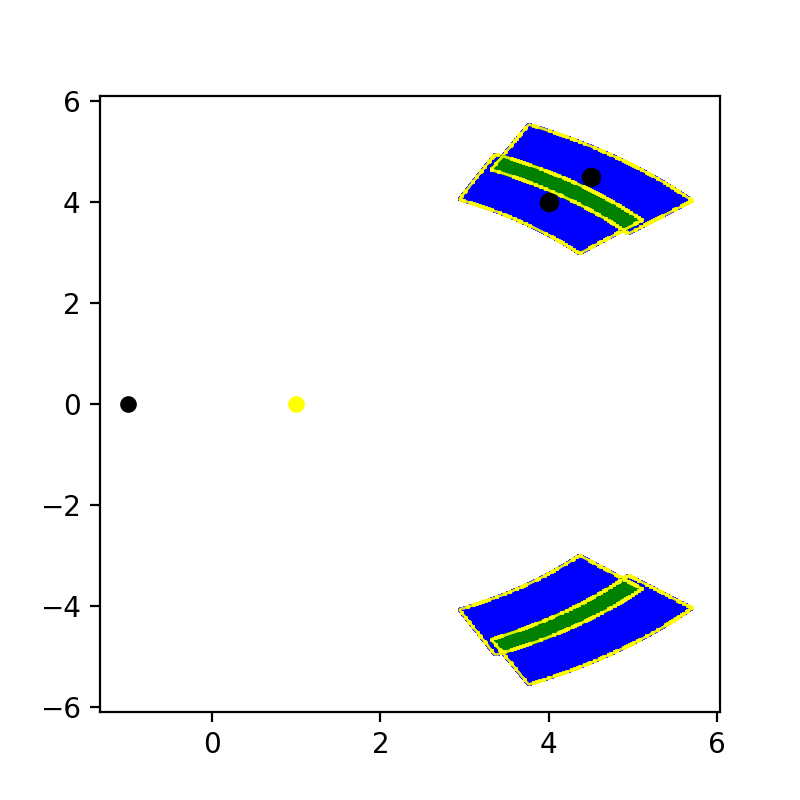

In [17]:
%matplotlib notebook
fig, ax = plt.subplots(1, 1, figsize=(4,4))

tracker.plot()

# Tracking the target state

As typically done in underwater target tracking, the following restricts the movement of the target on the x-y space.
The target is then represented through the following state vector:

$ \textbf{x}=[x, y, \dot{x}, \dot{y}]^T$,

where $x$ and $y$ are the target’s Cartesian coordinates, and $\dot{x}, \dot{y}$ are their derivatives with respect to time.




Let's initialise the variables as:

In [138]:
_x, dt = np.array([[5.],[-10.],[0.],[0.]]), 0.1

noise = 1*ia.Interval(-1, 1)

x_hist= [_x]

ks = range(0, 100) # time

And the target motion can be defined in Cartesian (North-East) coordinates and expressed in terms of a Markovian process:

$\textbf{x}_{k+1} = \mathbf{F}(\textbf{x}_k, \textbf{w}_k)$

where $\mathbf{F}(\dot)$ is a generic non-linear function, $\textbf{x}_k$ is the target motion state vector, and $\textbf{w}_k$ is the process noise.

The approach can be applied to any target motion model, however, following the approach proposed in [?] we adopt the nearly constant velocity model:


$\textbf{x}_{k+1} = A_k\textbf{x}_k + B_k \textbf{w}_k$,

where $A_k$ is the state transition matrix, $B_k \textbf{w}_k$ takes into account the target acceleration and other unmodelled dynamics.

This can be implemented as below:

In [139]:
def robot(dt, x, n_u):
    # n_u is a 2×1 vector, with zero mean and std σx along x, and σy along y.        
    A = np.array([[1, 0, dt, 0 ], 
                  [0, 1,  0, dt],
                  [0, 0,  1,  0],
                  [0, 0,  0,  1]])

    B = np.array([[dt**2, 0],
                  [0, dt**2],
                  [dt,    0],
                  [0,    dt]])

    x = A @ x + B @ n_u
    return x

The above code can be run to obtain the target motion over the simulation time $ks$:

In [143]:
for k in ks:
    nu_x = u.IA.rand_interval(noise)
    nu_y = u.IA.rand_interval(noise)

    _x = robot(dt, _x, np.array([[nu_x], [nu_y]]))
    x_hist.append(_x)

And the vector below shows the first entry:

In [144]:
x_hist[0]

array([[  5.],
       [-10.],
       [  0.],
       [  0.]])

And if we plot it:

<IPython.core.display.Javascript object>


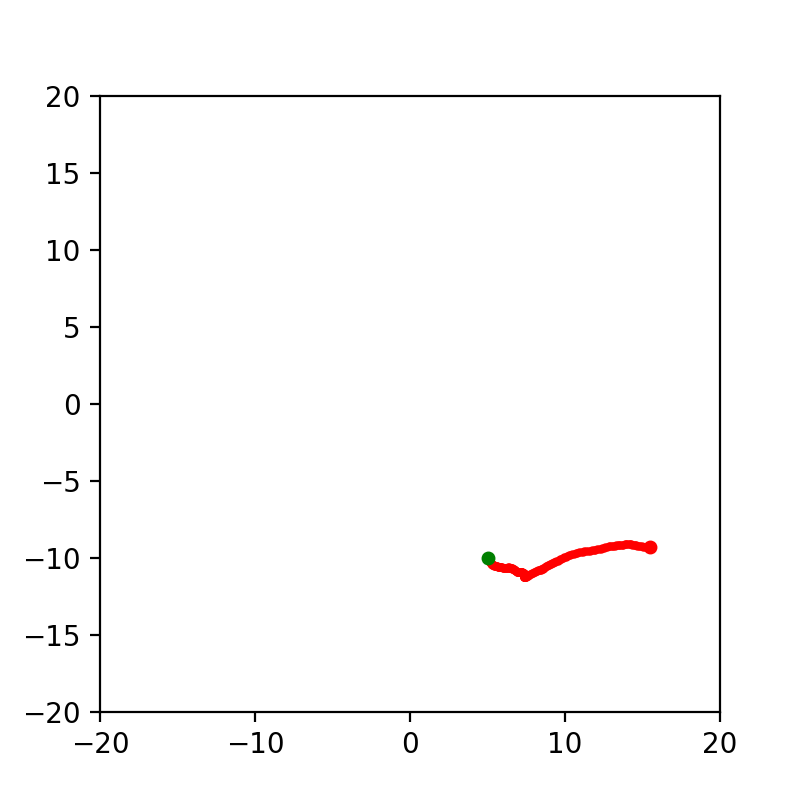

In [145]:
%matplotlib notebook
fig, ax = plt.subplots(1, 1, figsize=(4,4))

for x in x_hist:   
    plt.plot(x[0], x[1], color='red', marker='.', markersize=4)
    
plt.plot(x_hist[0][0], x_hist[0][1], color='green', marker='.', markersize=8)
plt.plot(x_hist[-1][0], x_hist[-1][1], color='red', marker='.', markersize=8)

ax.autoscale()
ax.set_xlim(-20, 20)
ax.set_ylim(-20, 20);

Based on the target model it is possible to define the state contractors, that are implemented as:

In [128]:
def contract_state(xp1, yp1, vxp1, vyp1, x, y, vx, vy, dt):
    """State Contraction. 
     The following vars are linked by a relation (hence we can contract them)
     and the relation is the state model.
     """
    
    # xp1=x+dtcos(theta)*v
    fx = ia.Function('xp1', 'x', 'vx', 'xp1-x-%f*vx' % (dt))
    fy = ia.Function('yp1', 'y', 'vy', 'yp1-y-%f*vy' % (dt))
    fvx = ia.Function('vxp1', 'vx', 'vxp1-vx')
    fvy = ia.Function('vyp1', 'vy', 'vyp1-vy')    
    
    contract_x = ia.CtcFwdBwd(fx, ia.Interval(0,0)) # This means fx==0
    contract_y = ia.CtcFwdBwd(fy, ia.Interval(0,0)) # This means fy==0    
    contract_vx = ia.CtcFwdBwd(fvx, ia.Interval(0,0)) # This means fx==0
    contract_vy = ia.CtcFwdBwd(fvy, ia.Interval(0,0)) # This means fy==0    
 
    # ask the contractors to contract the intervals
    Bx = ia.IntervalVector(3)  # 3 dimentions
    Bx[0], Bx[1], Bx[2] = xp1, x, vx
    contract_x.contract(Bx) # result will be in B_x
    xp1, x, vx = Bx[0], Bx[1], Bx[2] # store and update variables
    
    By = ia.IntervalVector(3)
    By[0], By[1], By[2] = yp1, y, vy
    contract_y.contract(By)
    yp1, y, vy = By[0], By[1], By[2]    
        
    Bvx = ia.IntervalVector(2)
    Bvx[0], Bvx[1] = vxp1, vx
    contract_vx.contract(Bvx)
    vxp1, vx = Bvx[0], Bvx[1]
    
    Bvy = ia.IntervalVector(2)
    Bvy[0], Bvy[1] = vyp1, vy
    contract_vy.contract(Bvy)
    vyp1, vy = Bvy[0], Bvy[1]
        
    return xp1, yp1, vxp1, vyp1, x, y, vx, vy

We can now run them:

In [146]:
# define our initial environment per each time step per variable
# list of 101 intervals ks[-1] is the final time
X = [ia.Interval(-20, 20) for i in range(0, ks[-1]+1) ] 

# initial position (known)
X[0] = ia.Interval(x_hist[0][0])

Y = [ia.Interval(-20, 20) for i in range(0, ks[-1]+1) ] 
Y[0] = ia.Interval(x_hist[0][1])

Vx = [ia.Interval(-1, 1) for i in range(0, ks[-1]+1) ] 

Vy = [ia.Interval(-1, 1) for i in range(0, ks[-1]+1) ] 


In [147]:
# interval propogation
for k in ks:
    # contraction. The following vars are linked by a relation (hence we can contract them)
    # and the relation is the state model
    # note that theta is measured because we have a compass.
    # If we do not have compass than we can return theta as well and contract it!
    # v is also know as it is the vehicle speed.
    X[k], Y[k], Vx[k], Vy[k], X[k-1], Y[k-1], Vx[k-1], Vy[k-1] = contract_state(X[k], Y[k], Vx[k], Vy[k], X[k-1], Y[k-1], Vx[k-1], Vy[k-1], dt)

<IPython.core.display.Javascript object>


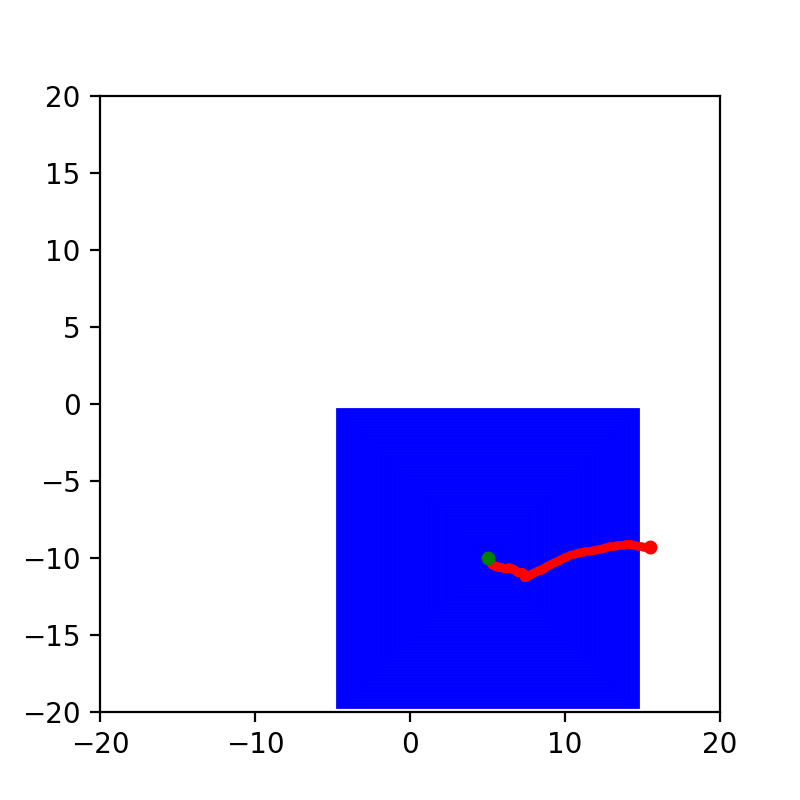

In [148]:
%matplotlib notebook
fig, ax = plt.subplots(1, 1, figsize=(4,4))
    
for x in x_hist:   
    plt.plot(x[0], x[1], color='red', marker='.', markersize=4)
    
plt.plot(x_hist[0][0], x_hist[0][1], color='green', marker='.', markersize=8)
plt.plot(x_hist[-1][0], x_hist[-1][1], color='red', marker='.', markersize=8)

    
X_reverse = X[::-1] 
Y_reverse = Y[::-1] 
#for x, y in zip(X, Y):
for x, y in zip(X_reverse, Y_reverse):
    #print(ia.IntervalVector([x,y]))
    u.IA.draw_box(ia.IntervalVector([x,y]), edgecolor='blue', facecolor='white')

#u.IA.draw_box(ia.IntervalVector([[-0.15, 0.15],[-0.3, 0.3]]), edgecolor='green', facecolor='white')    
u.IA.draw_box(ia.IntervalVector([X[1],Y[1]]), edgecolor='green', facecolor='white')    
u.IA.draw_box(ia.IntervalVector([X[-1],Y[-1]]), edgecolor='red', facecolor='white')    

ax.set_xlim(-20, 20)
We ax.set_ylim(-20, 20);

We are now ready to put everything together.

First, let's modify the previous code to include the sonar measurements.  
The target class above is modified to use the target positions calculated offline above.

In [221]:
class Target:
    def __init__(self, traj, name='T0'):
        self.x = traj
        self.name = name
        self.step = 0
    
    def do_step(self):
        out = self.x[self.step]
        self.step += 1
        return out
    
    def get_position(self):
        p = self.x[self.step]
        return float(p[0]), float(p[1])
    
        
    def plot(self):
        tmp = np.concatenate( target.x, axis=1 )
        plt.plot(tmp[0,:], tmp[1,:], marker='.', markersize=1, color='red')
        plt.plot(tmp[0,0], tmp[1,0], marker='.', markersize=10, color='green')
        plt.plot(tmp[0,-1], tmp[1,-1], marker='.', markersize=10, color='red')
        plt.plot(tmp[0,self.step], tmp[1,self.step], marker='.', markersize=10, color='blue')

    def __repr__(self):
        #        [print(x, y) for x,y in zip(self.x[0,:], self.x[1,:])]
        return f'Target {self.name}: x,y=({self.x[0][0]:5.2f}, {self.x[0][1]:5.2f})'



In [222]:
target = Target(x_hist)

<IPython.core.display.Javascript object>


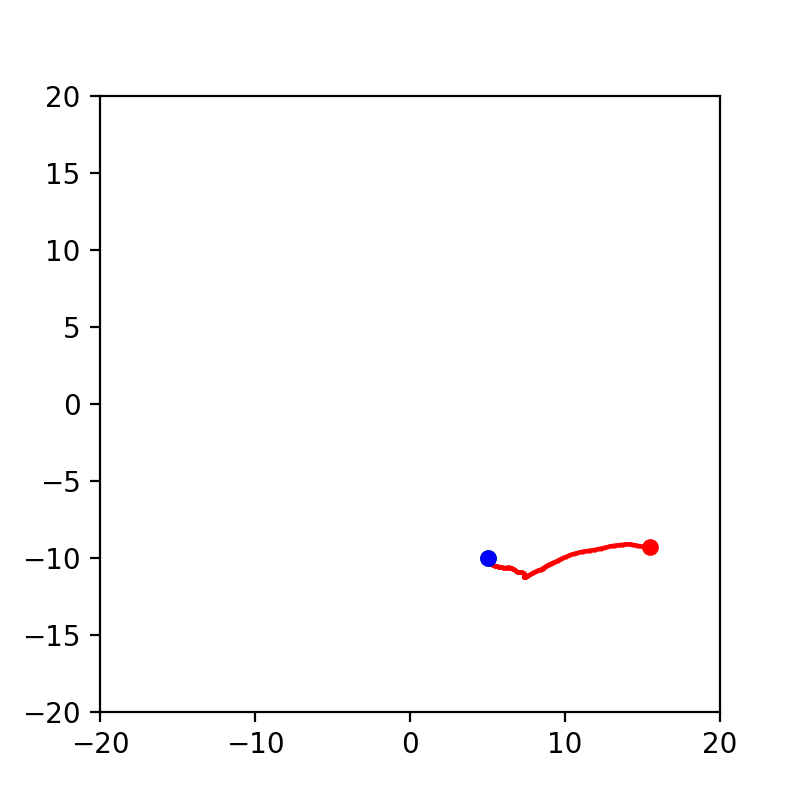

In [223]:
%matplotlib notebook
fig, ax = plt.subplots(1, 1, figsize=(4,4))

target.plot()
ax.set_xlim(-20, 20)
ax.set_ylim(-20, 20);

Let's now calculate the measurements that the sonar picks up when the target moves following its trajectory.

The sonar has the TX located in $(-1,0)$ and the RX in $(1,0)$.  
A range error of 0.5m and a bearing error of 0.2 deg(?) is also considered.


In [241]:
X = ia.IntervalVector([[-20, 20],[-20, 20]])
sonar = Sonar(tx=(-1, 0), rx=(1, 0, 0), err_range = 0.5, err_bearing = 0.2)
tracker = IA2DTracker2(sonar)

# create a target with the previous trajectory (x_hist)
target = Target(x_hist)

<IPython.core.display.Javascript object>


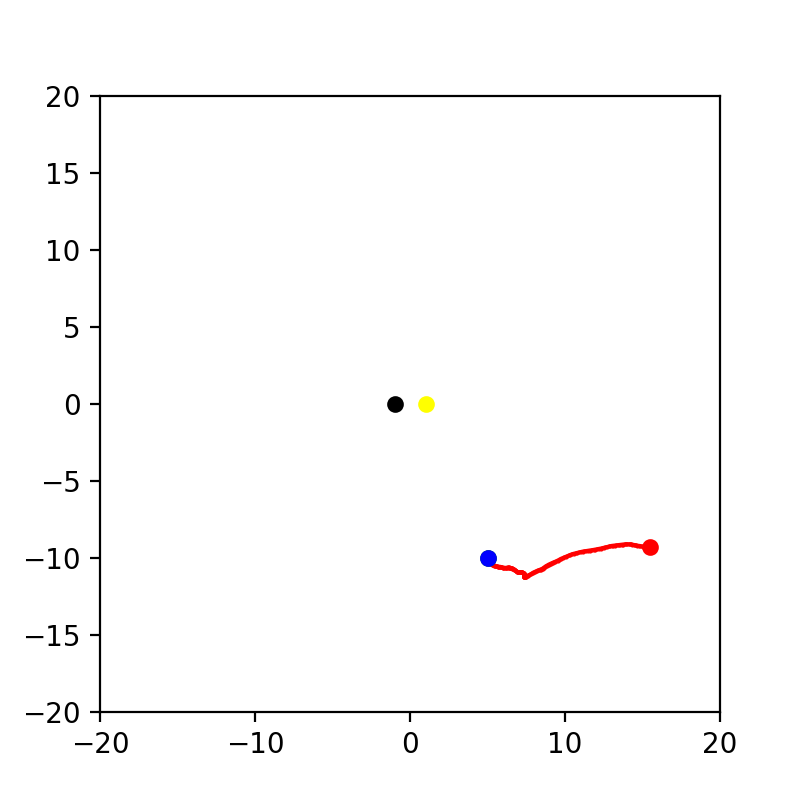

In [244]:
%matplotlib notebook
fig, ax = plt.subplots(1, 1, figsize=(4,4))

sonar.plot()
target.plot()
ax.set_xlim(-20, 20)
ax.set_ylim(-20, 20);

In [245]:
t_range, t_bearing = sonar.detect(target.get_position()) # bistatic values

In [246]:
t_range, t_bearing

(22.432233403959607, -1.1902899496825317)

If this is done per every time step:

In [247]:
r_hist, b_hist = [], []
for k in ks:
    t_range, t_bearing = sonar.detect(target.get_position()) # bistatic values
    r_hist.append(t_range)
    b_hist.append(t_bearing)
    target.do_step()

<IPython.core.display.Javascript object>


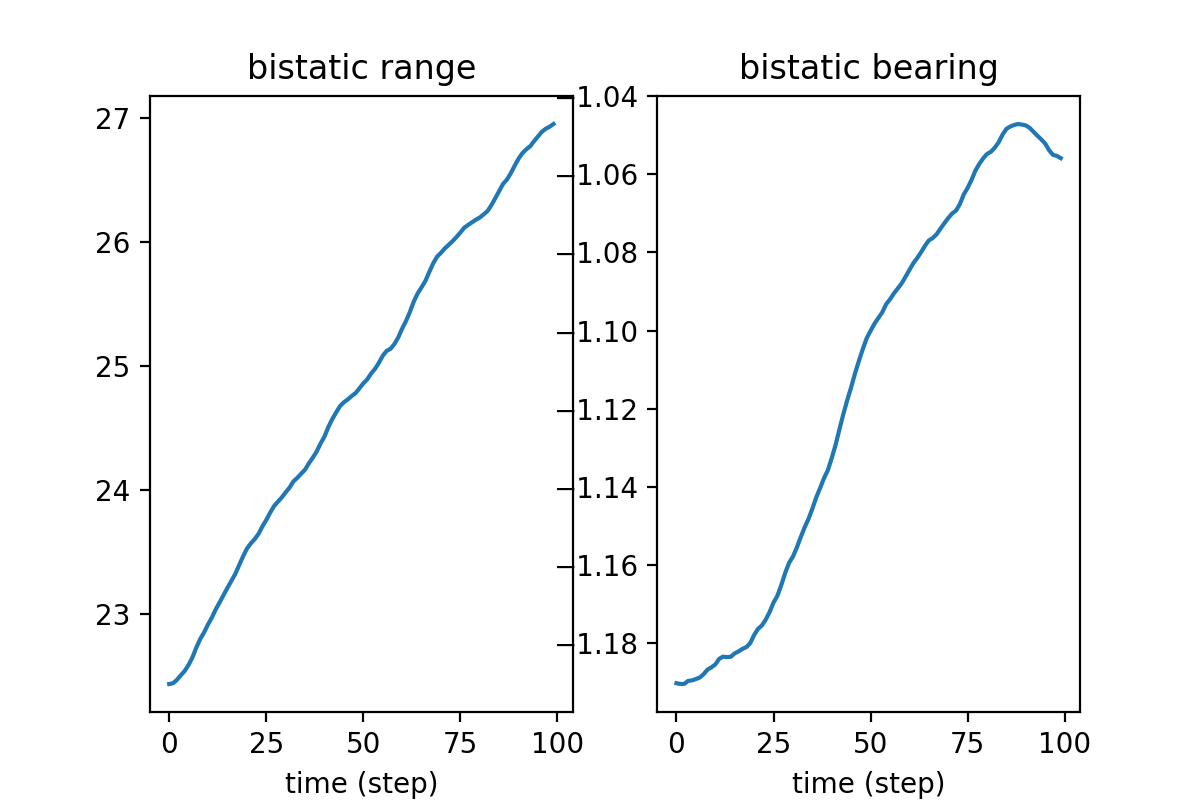

In [253]:
%matplotlib notebook
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6,4))

ax1.plot(r_hist)
ax1.set_title('bistatic range')
ax1.set_xlabel('time (step)')

ax2.plot(b_hist)
ax2.set_title('bistatic bearing')
ax2.set_xlabel('time (step)');

To see what happens when we apply the IA2DTracker, for a single target position:

In [231]:
X = ia.IntervalVector([[-20, 20],[-20, 20]])
sonar = Sonar(tx=(-1, 0), rx=(1, 0, 0), err_range = 0.5, err_bearing = 0.2)
tracker = IA2DTracker2(sonar)

tgt = Target(x_hist)

tracker.add_detections([tgt])

In [232]:
a = tgt.get_position()

In [236]:
tracker.get_all_intersections(X, epsilon=0.1);

- get_intersections: q:0
number of separation 543 / number of boxes 819
len(in_boxes) list is: 2


<IPython.core.display.Javascript object>


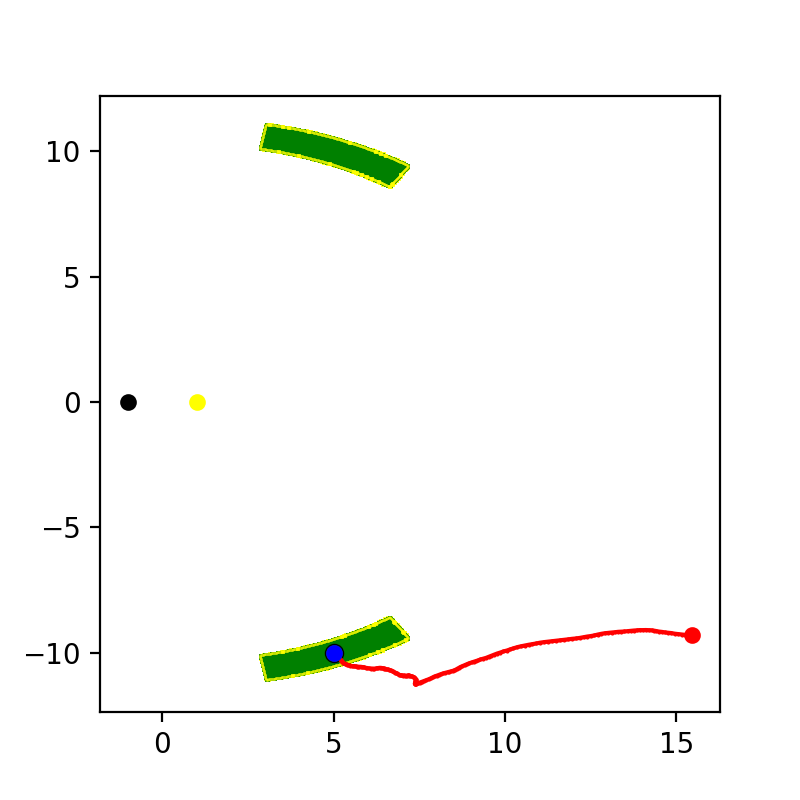

In [237]:
%matplotlib notebook
fig, ax = plt.subplots(1, 1, figsize=(4,4))

tracker.plot()
target.plot()

Again, we modify the previous code to include the knowledge on the sonar measurements.  


In this case, we use the same initial intervals that we used for the target position (-20, 20), but if their position is totally unknown we can use (-inf, inf).

In [ ]:
def contract_sonar(self, x, y, sonar, t_range, t_bearing):
        """track_one_contact applies the measurement functions and generates separators based on the measurements."""
        t_rx_range, t_rx_bearing = sonar.refer_to_rx(t_range, t_bearing) # referred to the rx position
        
        rx_x, rx_y, rx_theta = sonar.get_rx() 
        err_range, err_bearing = sonar.get_errors()
        
        I_range = ia.Interval(t_rx_range-err_range, t_rx_range+err_range)
        I_bearing = ia.Interval( t_rx_bearing-err_bearing, t_rx_bearing + err_bearing)

        
        f_forward = ia.Function('Sx', 'Sy', '(%f + Sx; %f + Sy)' % (rx_x, rx_y))
        f_backward = ia.Function('tgt_x', 'tgt_y', '(tgt_x-%f; tgt_y-%f)' % (rx_x, rx_y))


        contract_d = ia.CtcFwdBwd(f, sqr(d)) # This means f==d (note that d is an interval)


        
         # xp1=x+dtcos(theta)*v
    fx = ia.Function('xp1', 'x', 'vx', 'xp1-x-%f*vx' % (dt))
    fy = ia.Function('yp1', 'y', 'vy', 'yp1-y-%f*vy' % (dt))
    fvx = ia.Function('vxp1', 'vx', 'vxp1-vx')
    fvy = ia.Function('vyp1', 'vy', 'vyp1-vy')    
    
    contract_x = ia.CtcFwdBwd(fx, ia.Interval(0,0)) # This means fx==0
    contract_y = ia.CtcFwdBwd(fy, ia.Interval(0,0)) # This means fy==0    
    contract_vx = ia.CtcFwdBwd(fvx, ia.Interval(0,0)) # This means fx==0
    contract_vy = ia.CtcFwdBwd(fvy, ia.Interval(0,0)) # This means fy==0    
 
    # ask the contractors to contract the intervals
    Bx = ia.IntervalVector(3)  # 3 dimentions
    Bx[0], Bx[1], Bx[2] = xp1, x, vx
    contract_x.contract(Bx) # result will be in B_x
    xp1, x, vx = Bx[0], Bx[1], Bx[2] # store and update variables
    
        
        
#         separator_port = SepPolarXY(I_range, I_bearing)
#         separator_starbrd = SepPolarXY(I_range, -I_bearing)

#         f_forward = ia.Function('Sx', 'Sy', '(%f + Sx; %f + Sy)' % (rx_x, rx_y))
#         f_backward = ia.Function('tgt_x', 'tgt_y', '(tgt_x-%f; tgt_y-%f)' % (rx_x, rx_y))

#         separator_t_port = ia.SepTransform(separator_port, f_backward, f_forward)
#         separator_t_starbrd = ia.SepTransform(separator_starbrd, f_backward, f_forward)
        
#         return separator_t_port | separator_t_starbrd
                                          
    

In [ ]:
def contract_landmarks(x, y, mx, my, d):
    # we define the function to use to contract which is simply the distance.
    f = Function('x', 'y', 'mx', 'my', '(x-mx)^2 + (y-my)^2')
        
    contract_d = CtcFwdBwd(f, sqr(d)) # This means f==d (note that d is an interval)
    
    # ask the contractors to contract the intervals
    box = IntervalVector(4)  # dimentions 4 because we have 4 variables
    box[0], box[1], box[2], box[3] = x, y, mx, my
    contract_d.contract(box) # result will be in box
    x, y, mx, my = box[0], box[1], box[2], box[3]  # store and update variables
    
    return x, y, mx, my

In [ ]:
# interval propogation
for k in ks:
    # contraction. The following vars are linked by a relation (hence we can contract them)
    # and the relation is the state model
    # note that theta is measured because we have a compass.
    # If we do not have compass than we can return theta as well and contract it!
    # v is also know as it is the vehicle speed.
    X[k], Y[k], Vx[k], Vy[k], X[k-1], Y[k-1], Vx[k-1], Vy[k-1] = contract_state(X[k], Y[k], Vx[k], Vy[k], X[k-1], Y[k-1], Vx[k-1], Vy[k-1], dt)    
    
# contract the trajectory with respect to the landmarks
for k in range(0, ks[-1]):
    j = land_hist[k] # select the correct landmark seen at time k    
    X[k], Y[k], Mx[j], My[j] = contract_sonar(X[k], Y[k], Mx[j], My[j], d_hist[k])

In [ ]:
 def bistatic_separators(self, target):
        """track_one_contact applies the measurement functions and generates separators based on the measurements."""
        t_range, t_bearing       = self.sonar.detect(target.get_position()) # bistatic values
        t_rx_range, t_rx_bearing = sonar.refer_to_rx(t_range, t_bearing) # referred to the rx position
        
        rx_x, rx_y, rx_theta = self.sonar.get_rx() 
        err_range, err_bearing = sonar.get_errors()
        
        I_range = ia.Interval(t_rx_range-err_range, t_rx_range+err_range)
        I_bearing = ia.Interval( t_rx_bearing-err_bearing, t_rx_bearing + err_bearing)

        separator_port = SepPolarXY(I_range, I_bearing)
        separator_starbrd = SepPolarXY(I_range, -I_bearing)

        f_forward = ia.Function('Sx', 'Sy', '(%f + Sx; %f + Sy)' % (rx_x, rx_y))
        f_backward = ia.Function('tgt_x', 'tgt_y', '(tgt_x-%f; tgt_y-%f)' % (rx_x, rx_y))

        separator_t_port = ia.SepTransform(separator_port, f_backward, f_forward)
        separator_t_starbrd = ia.SepTransform(separator_starbrd, f_backward, f_forward)
        
        return separator_t_port | separator_t_starbrd
                                          
    
    def get_all_intersections(self, X, epsilon=0.1):                            
        in_boxes, out_boxes, maybe_boxes, qs = [], [], [], []
        for q in range(0, len(self.detections)):
            print(f'- get_intersections: q:{q}')            
            
            separators = []
            for idx, d in enumerate(self.detections):
                separators.append(self.bistatic_separators(d))

            # we want now to do the relaxed intersection    
            qrelaxed_separator = ia.SepQInterProjF(separators)                  
            qrelaxed_separator.q = q # number of set to relax

            inb, outb, mayb = ia.pySIVIA(X, qrelaxed_separator, epsilon=epsilon, draw_boxes=False) 
            
            self.in_boxes.append(inb)
            self.out_boxes.append(outb)
            self.maybe_boxes.append(mayb)
            qs.append(q)
            
        self.in_boxes.reverse()
        self.out_boxes.reverse()
        self.maybe_boxes.reverse()
                    
        print(f'len(in_boxes) list is: {len(self.in_boxes)}')                     
    

## From here is only crapified stuff that I dumped

In [239]:
class Track:
    def __init__(self, x = None, t = None):
        self.x0, self.t0 = x, t
        self.x1, self.t1 = None, None
        self.x = None
        
        
    def move(dt, n_u):
        # n_u is a 2×1 vector, with zero mean and std σx along x, and σy along y.        
        A = np.array([[1, 0, dt, 0 ], 
                      [0, 1,  0, dt],
                      [0, 0,  1,  0],
                      [0, 0,  0,  1]])

        B = np.array([[dt**2, 0],
                      [0, dt**2],
                      [dt,    0],
                      [0,    dt]])

        self.x = A @ self.x + B @ n_u
        return self.x
    
    def set_x1(self, x, t):                
        self.x1, self.t1 = x, t
        print('Track: track initialised (two points available)')
        dt = self.t1 - self.t0
        vx = (self.x1[0] - self.x0[0])/dt
        vy = (self.x1[1] - self.x0[1])/dt        
        self.x = np.array([[self.x1[0]], [self.x1[1]], [], []])


In [ ]:
# interval propagation
for k in range(1, ks[-1]+1):
    # contraction. The following vars are linked by a relation (hence we can contract them)
    # and the relation is the state model
    # note that theta is measured because we have a compass.
    # If we do not have compass than we can return theta as well and contract it!
    # v is also know as it is the vehicle speed.
    X[k], Y[k], X[k-1], Y[k-1] = contract_state(X[k], Y[k], X[k-1], Y[k-1], Th[k-1], v)

# contract the trajectory with respect to the landmarks
for k in range(0, ks[-1]):
    j = land_hist[k] # select the correct landmark seen at time k    
    X[k], Y[k], Mx[j], My[j] = contract_sonar(X[k], Y[k], Mx[j], My[j], d_hist[k])

In [ ]:


# here we need every Th to be an interval that contains the true value for theta
Th = [th_hist[i] for i in range(0,ks[-1]+1)] 

# interval propagation
for k in range(1, ks[-1]+1):
    # contraction. The following vars are linked by a relation (hence we can contract them)
    # and the relation is the state model
    # note that theta is measured because we have a compass.
    # If we do not have compass than we can return theta as well and contract it!
    # v is also know as it is the vehicle speed.
    X[k], Y[k], X[k-1], Y[k-1] = contract_state(X[k], Y[k], X[k-1], Y[k-1], Th[k-1], v)

# contract the trajectory with respect to the landmarks
for k in range(0, ks[-1]):
    j = land_hist[k] # select the correct landmark seen at time k    
    X[k], Y[k], Mx[j], My[j] = contract_landmarks(X[k], Y[k], Mx[j], My[j], d_hist[k])


In [ ]:
def robot(dt, x, y, theta, v, u, n_u):
    xp1 = x + v*dt*np.cos(theta)
    yp1 = y + v*dt*np.sin(theta)
    thetap1 = theta + dt*(u+n_u)
    return xp1, yp1, thetap1

In [ ]:
_x, _y, _th, dt = 0, 0, 1, 0.1

noise = 0.03*ia.Interval(-1, 1)

x_hist, y_hist, th_hist = [_x], [_y], [_th + noise]    

ks = range(0, 100) # time

In [64]:
for k in ks:
    _v   = 10
    _u   = 3*np.sin(k*dt)**2
    n_u = u.IA.rand_interval(noise)

    _x, _y, _th = robot(dt, _x, _y, _th, _v, _u, n_u)
    x_hist.append(_x), y_hist.append(_y), th_hist.append(_th + noise)

<IPython.core.display.Javascript object>


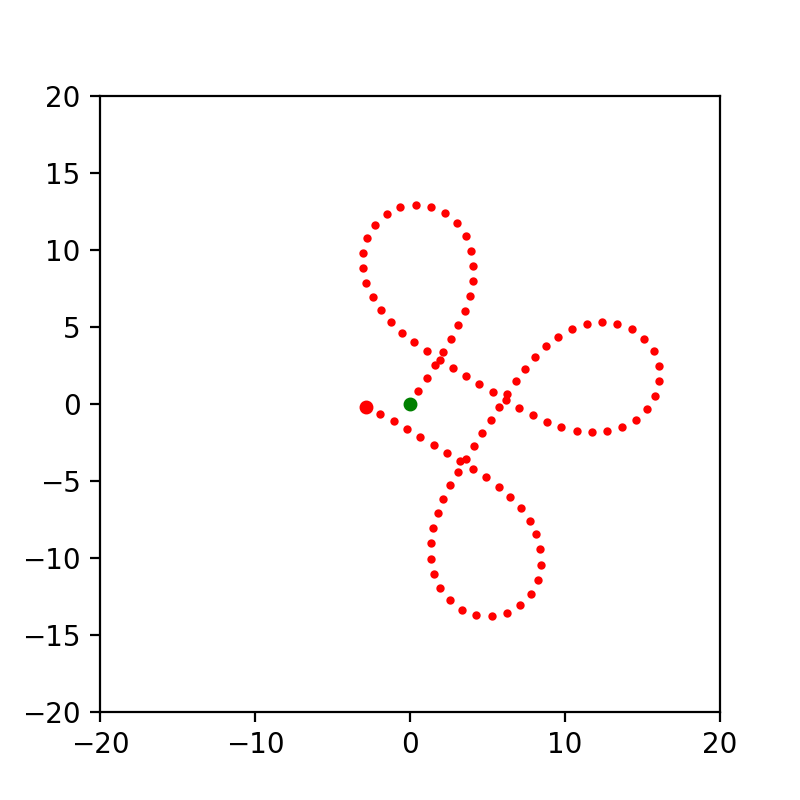

In [66]:
%matplotlib notebook
fig, ax = plt.subplots(1, 1, figsize=(4,4))

for x, y in zip(x_hist, y_hist):   
    plt.plot(x, y, color='red', marker='.', markersize=4)
    
plt.plot(x_hist[0], y_hist[0], color='green', marker='.', markersize=8)
plt.plot(x_hist[-1], y_hist[-1], color='red', marker='.', markersize=8)

ax.autoscale()
ax.set_xlim(-20, 20)
ax.set_ylim(-20, 20);

In [68]:
# define our initial environment per each time step.
X = [ ia.Interval(-20, 20) for i in range(0, ks[-1]+1) ] # list of 101 intervals ks[-1] is the final time
# initial position (known)
X[0] = ia.Interval(x_hist[0])
Y = X.copy()

# here we need every Th to be an interval that contains the true value for theta
Th = [th_hist[i] for i in range(0,ks[-1]+1)] 

In [81]:
def contract_state(xp1, yp1, x, y, th, v):
    """Contraction. The following vars are linked by a relation (hence we can contract them)
     and the relation is the state model
     note that theta is measured because we have a compass.
     If we do not have compass than we can return theta as well and contract it! 
     """
    
    # xp1=x+dtcos(theta)*v
    fx = ia.Function('xp1', 'x', 'th', 'xp1-x-%f*%f*cos(th)' % (dt, v))
    fy = ia.Function('yp1', 'y', 'th', 'yp1-y-%f*%f*sin(th)' % (dt, v))

#     fx = ia.Function("x_1", "x", "th", "x_1-x-%f*v*cos(th)" % dt)
#     fy = ia.Function("y_1", "y", "th", "y_1-y-%f*v*sin(th)" % dt)
    
    
    contract_x = ia.CtcFwdBwd(fx, ia.Interval(0,0)) # This means fx==0
    contract_y = ia.CtcFwdBwd(fy, ia.Interval(0,0)) # This means fy==0    
    
    # ask the contractors to contract the intervals
    Bx = ia.IntervalVector(3)  # 3 dimentions
    Bx[0], Bx[1], Bx[2] = xp1, x, th
    contract_x.contract(Bx) # result will be in B_x
    xp1, x, th = Bx[0], Bx[1], Bx[2] # store and update variables
    
    By = ia.IntervalVector(3)
    By[0], By[1], By[2] = yp1, y, th
    contract_y.contract(By)
    yp1, y, th = By[0], By[1], By[2]    
        
    return xp1, yp1, x, y#, th, v

In [82]:
# interval propogation
for k in ks:
    # contraction. The following vars are linked by a relation (hence we can contract them)
    # and the relation is the state model
    # note that theta is measured because we have a compass.
    # If we do not have compass than we can return theta as well and contract it!
    # v is also know as it is the vehicle speed.
    X[k], Y[k], X[k-1], Y[k-1] = contract_state(X[k], Y[k], X[k-1], Y[k-1], Th[k-1], v)

<IPython.core.display.Javascript object>


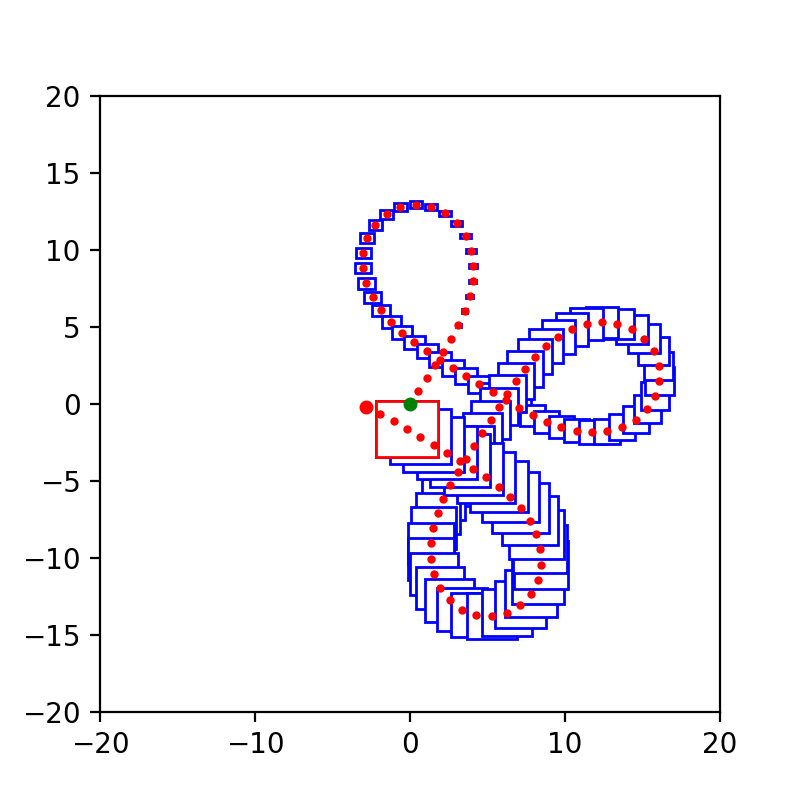

In [84]:
%matplotlib notebook
fig, ax = plt.subplots(1, 1, figsize=(4,4))
    
for x, y in zip(x_hist, y_hist):   
    plt.plot(x, y, color='red', marker='.', markersize=4)
    
plt.plot(x_hist[0], y_hist[0], color='green', marker='.', markersize=8)
plt.plot(x_hist[-1], y_hist[-1], color='red', marker='.', markersize=8)
    

for x, y in zip(X, Y):
    u.IA.draw_box(ia.IntervalVector([x,y]), edgecolor='blue', facecolor='white')


u.IA.draw_box(ia.IntervalVector([X[1],Y[1]]), edgecolor='green', facecolor='white')    
u.IA.draw_box(ia.IntervalVector([X[-3],Y[-3]]), edgecolor='red', facecolor='white')    

ax.set_xlim(-20, 20)
ax.set_ylim(-20, 20);

# Drawing 3D boxes

<IPython.core.display.Javascript object>


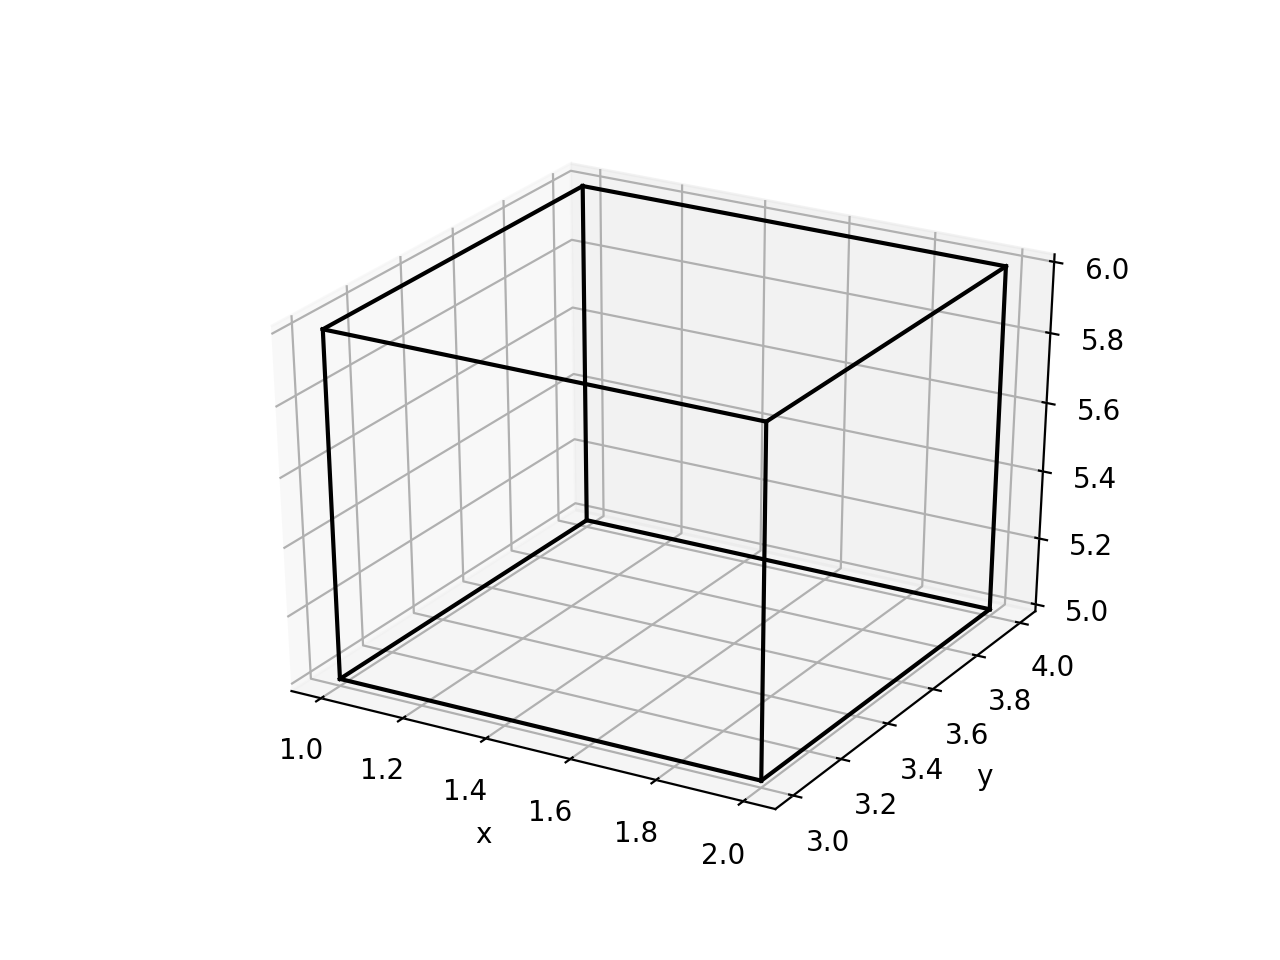

In [136]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from itertools import product, combinations
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection

fig = plt.figure()

def _draw_empty_box_3d(x_lo, x_up, y_lo, y_up, z_lo, z_up, edgecolor='black', facecolor='blue', ax=None):
    if ax is None: ax = plt.gca(projection='3d')
    xyz = (x_lo,y_lo,z_lo)
    
    width  = x_up-x_lo
    height = z_up-z_lo
    length = y_up-y_lo
    
    for a, b in combinations(np.array(list(product([x_lo, x_up], [y_lo, y_up], [z_lo, z_up]))), 2):
        if np.sum(np.abs(a-b)) == width or np.sum(np.abs(a-b)) == height or np.sum(np.abs(a-b)) == length:
            x, y, z = zip(a,b)
            ax.plot3D(x, y, z, color=edgecolor)
    return ax     
        
# draw to test
ax = _draw_empty_box_3d(1,2,3,4,5,6)
ax.set_xlabel('x')
ax.set_ylabel('y');

<IPython.core.display.Javascript object>


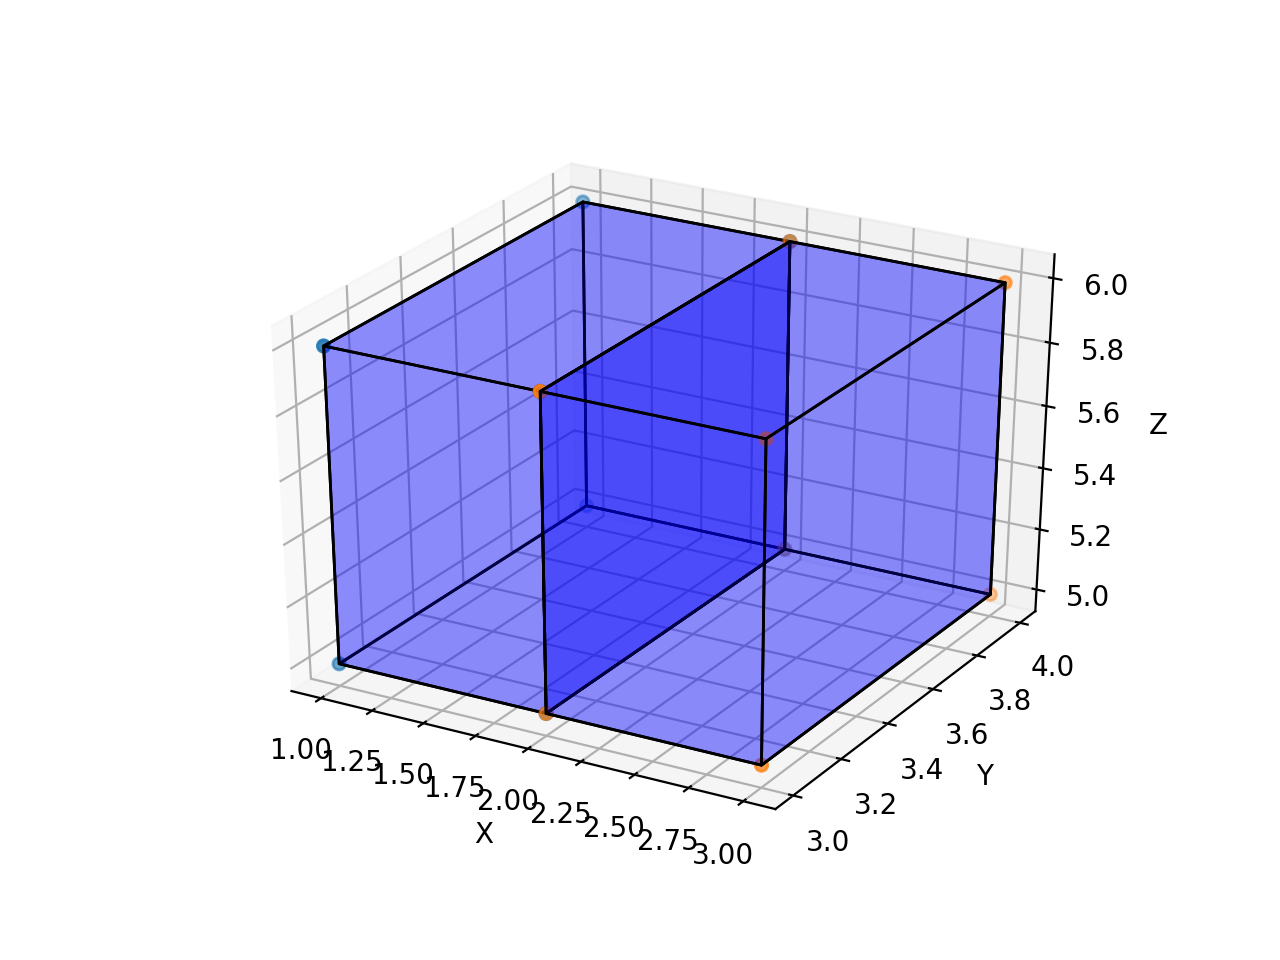

In [137]:
def _draw_box_3d(x_lo, x_up, y_lo, y_up, z_lo, z_up, edgecolor='black', facecolor='blue', alpha=0.25, ax=None, plot_vertices=False):
    """plots a 3D box.
    fig = plt.figure()
    _draw_box_3d2(1,2,3,4,5,6) 
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    """
    
    if ax is None: ax = plt.gca(projection='3d')        
    xyz = (x_lo,y_lo,z_lo)    
    width_1 = x_up-x_lo
    width_2 = y_up-y_lo
    height = z_up-z_lo
    points = np.array([[x_lo, y_lo, z_lo],
                      [x_up, y_lo, z_lo],
                      [x_up, y_up, z_lo],
                      [x_lo, y_up, z_lo],
                      [x_lo, y_lo, z_up],
                      [x_up, y_lo, z_up],
                      [x_up, y_up, z_up],
                      [x_lo, y_up, z_up]])


    Z = np.zeros((8,3))
    for i in range(8): Z[i,:] = points[i,:]

    if plot_vertices: ax.scatter3D(Z[:, 0], Z[:, 1], Z[:, 2])

    # list of sides' polygons of figure

    verts = [[Z[0],Z[1],Z[2],Z[3]],
             [Z[4],Z[5],Z[6],Z[7]], 
             [Z[0],Z[1],Z[5],Z[4]], 
             [Z[2],Z[3],Z[7],Z[6]], 
             [Z[1],Z[2],Z[6],Z[5]],
             [Z[4],Z[7],Z[3],Z[0]]]

    # plot sides
    ax.add_collection3d(Poly3DCollection(verts, facecolors=facecolor, linewidths=1, edgecolors=edgecolor, alpha=alpha))
    return ax
   


fig = plt.figure()
_draw_box_3d(1,2,3,4,5,6, plot_vertices=True) 
ax = _draw_box_3d(2,3,3,4,5,6, plot_vertices=True) 
ax.autoscale()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z');

# References

[1] [drawing-3d-boxes](https://stackoverflow.com/questions/44881885/python-draw-parallelepiped)  
[2] [pyglet-demo](https://www.youtube.com/watch?v=Hqg4qePJV2U)  
[3] [multiple-references](https://medium.com/@fkariminejadasl/multiple-target-tracking-6de2a68ae202)  
[4] [ia slides](https://agora.bourges.univ-orleans.fr/ramdani/gtmea/legacy/www2.lirmm.fr/ensemble/IMG/pdf/Soares_MEA.pdf)  
[5] [ia radar](https://ieeexplore.ieee.org/document/4527002)